In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib

matplotlib.rc('font', family='Heiti TC')

In [3]:
# read data from csv
df = pd.read_csv('test.csv')
print(df[df['n_tokens'] < 40].shape[0])
print(df[df['n_tokens'] > 800].shape[0])

5478
1308


(63180, 8)
(61784, 8)


Text(0, 0.5, 'Density')

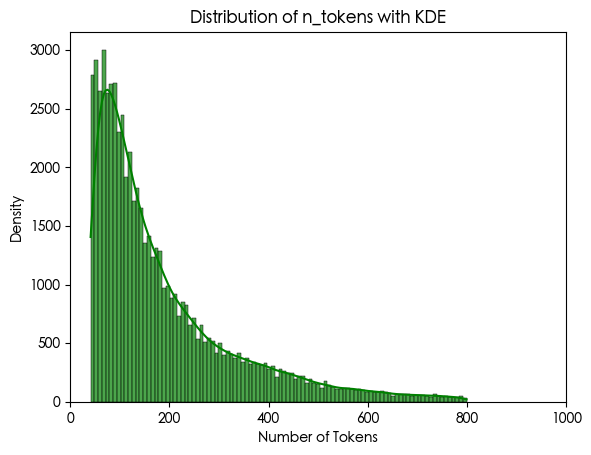

In [8]:
## keep n_tokens between 40 and 800
df = df[(df['n_tokens'] > 40) & (df['n_tokens'] < 800)]

## drop duplicates
print(df.shape)
df.drop_duplicates(subset=['place_id','user_id'],inplace=True)
print(df.shape)

sns.histplot(df['n_tokens'], kde=True, color='green', bins=100, alpha=0.7)
plt.xlim(0,1000)
plt.title('Distribution of n_tokens with KDE')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')


In [9]:
# clustering
# convert embeddings to np.array metrix
df["embeddings"] = df.embeddings.apply(literal_eval).apply(np.array)
matrix = np.vstack(df.embeddings.values)
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=5)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

In [10]:
# create UMAP reducer
reducer = umap.UMAP(n_neighbors=100,min_dist=0.1, n_components=2, metric='cosine')
data_umap = reducer.fit_transform(matrix)
df['umap_1'] = data_umap[:, 0]
df['umap_2'] = data_umap[:, 1]

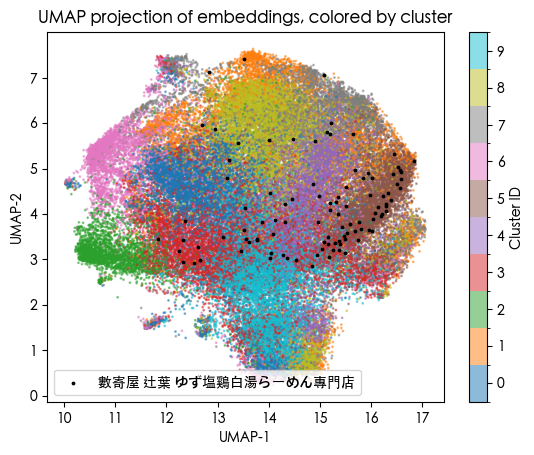

In [11]:
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(-0.5, n_clusters + 0.5, 1), cmap.N)

mask = df['name'] == "數寄屋 辻葉 ゆず塩鷄白湯らーめん專門店"

scatter = plt.scatter('umap_1', 'umap_2', s=1, c=labels, cmap=cmap, data=df,
                        norm=norm, alpha=0.5,label='')
plt.scatter(data_umap[mask, 0], data_umap[mask, 1], s=3, color='black',
                        alpha=1, label='數寄屋 辻葉 ゆず塩鷄白湯らーめん專門店')
plt.colorbar(scatter, ticks=np.arange(n_clusters), label='Cluster ID')  # Adjust colorbar to show discrete values
plt.title('UMAP projection of embeddings, colored by cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend()

In [52]:
# show clusters distribution of a ramen 數寄屋 辻葉 ゆず塩鷄白湯らーめん專門店
print(df[mask].groupby('Cluster').size().sort_values(ascending=False)
        .reset_index(name='Count')
        .assign(Percentage=lambda x: (x['Count'] / x['Count'].sum()) * 100)
        .assign(Accumulated=lambda x: (x['Percentage'].cumsum()) ))

# consider cluster 5,3,9,1 as features of 數寄屋 

   Cluster  Count  Percentage  Accumulated
0        5     40   39.215686    39.215686
1        3     21   20.588235    59.803922
2        9     15   14.705882    74.509804
3        1     10    9.803922    84.313725
4        8      9    8.823529    93.137255
5        4      3    2.941176    96.078431
6        0      2    1.960784    98.039216
7        7      2    1.960784   100.000000


Text(0, 0.5, 'UMAP-2')

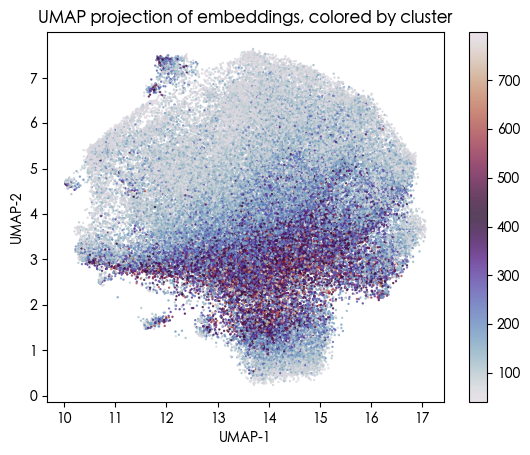

In [12]:
norm = Normalize(vmin=df['n_tokens'].min(), vmax=df['n_tokens'].max())

scatter2 = plt.scatter('umap_1', 'umap_2', s=0.5, c='n_tokens', cmap='twilight', data=df,
                        alpha=0.8,label='')
plt.colorbar(scatter2)
plt.title('UMAP projection of embeddings, colored by cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

In [27]:
## extract centroids from kmeans
centroids = kmeans.cluster_centers_

## check the vector dimensions
for i, centroid in enumerate(centroids):
    print(i,"\t",len(centroid))

0 	 1536
1 	 1536
2 	 1536
3 	 1536
4 	 1536
5 	 1536
6 	 1536
7 	 1536
8 	 1536
9 	 1536


In [105]:
## show the reviews with 5 highest similarity to the cluster's centroids
similarities_list = []
for i, centroid in enumerate(centroids):
    # 計算每個聚類中心與其它點的相似性
    similarities = cosine_similarity([centroid],np.vstack(df[df.Cluster == i].embeddings.values))[0]
    similarities_list.extend(similarities)

df['similarities'] = similarities_list
    
for i in range(n_clusters):
    print(f"Cluster {i} 的代表評論：")
    print(df[df.Cluster == i].sort_values('similarities',ascending=False).combined.apply(lambda x: x.split('Content: ')[1])[0:5])
    print("\n")



Cluster 0 的代表評論：
32588    特地來霧峰嚐鮮排隊美食🫶 麵屋黑心🖤 真心覺得不錯吃餒😻雞肉與豚骨肉好好吃😋 下回再來吃不同...
38657    看到評價不錯，特別過來吃，裡面可以自己掃描點餐，點了一碗豚骨拉麵，看店家說沒有添加任何化學和...
31487                   新店不可錯過的日式拉麵之一 建議吃到一半時添加桌上的大蒜與醋享受味變
68021              拉麵好吃，真的不輸那些名店的拉麵，還能依照自己的喜好客製拉麵口味，推薦大家來吃
37564     服務人員都會桌邊詢問 需不需要小菜、炸物～覺得蠻貼心的 拉麵可以自製diy 選自己喜歡吃的配料😆
Name: combined, dtype: object


Cluster 1 的代表評論：
29083    店內裝潢明亮，用餐環境舒適 本次用餐點的是海老沾麵，湯頭能嚐到滿滿的蝦之鮮味，同時又不會感到...
34810    美味，連平日下午加我也有6位客人！  不過口味不算是我的菜 太鹹或太濃都可以加高湯 可能上了...
67174    湯頭很濃郁，但我衝動了， 可以不用加湯+20（加蔥+40） 限量的松阪豬很嫩👍 炙燒鮭魚入口...
63478    2020.01.05  #元祖男子漢套餐  湯頭濃郁不死鹹  價位平價  炸蝦比想像中小 但...
19043    怕海鮮腥味的人可以放心嘗試，個人偏好加一點豚骨湯層次比較多元，原味雖然沒有想像中中厚重，但是...
Name: combined, dtype: object


Cluster 2 的代表評論：
31751    沒吃到餐點 2024/1/26 晚上七點用餐時間 位置大約一半為空  店員很努力地前後場跑來...
63103           點3份麵只來1份是怎樣啊 客服等他媽一個禮拜都沒回應 現在做生意是老二很大不用理人？
67838                       打電話去訂 接電話那個女生 像死人一樣 不知道是欠他多少❤️
67077    第一次來消費點了，咖哩牛肉飯180元牛肉四小塊，吃第一塊有冰箱味道，第一時間反應，店家回答我...
35577    用餐氣氛有夠吵 根本像極了菜市場交響樂 真的不會推薦來這家 而且同行友人吃完 回去都說拉肚子...


In [86]:
## sort by n_tokens and calculate token accumulation by clusters
df['accumulated_n_tokens'] = df.groupby('Cluster').apply(lambda group: group['n_tokens'].iloc[np.argsort(group['similarities'].values)[::-1]].cumsum()).reset_index(level=0, drop=True)

/var/folders/3k/syzcms_55r97fjwz1s3h8kkm0000gn/T/ipykernel_86228/2335842415.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['accumulated_n_tokens'] = df.groupby('Cluster').apply(lambda group: group['n_tokens'].iloc[np.argsort(group['similarities'].values)[::-1]].cumsum()).reset_index(level=0, drop=True)


In [114]:
## double check
df[df.Cluster == 7][df[df.Cluster == 7].accumulated_n_tokens<16000].sort_values('accumulated_n_tokens')

,Unnamed: 0,name,place_id,user_id,rating,combined,n_tokens,embeddings,Cluster,umap_1,umap_2,similarities,accumulated_n_tokens
63826,1212,宮內屋,ChIJnWrLb7OuQjQRGiY9k9L0uB0,108558747375454324069,4,Score: ★★★★; Content: 看到限時料理震撼登場~每日限量30份~就忍不住想...,118,"[0.014899932779371738, -0.022665003314614296, ...",7,13.290475,5.148411,0.920832,118
66696,4151,原味優品拉麵店,ChIJdcCJEAmsaTQR-s_nbFudAsI,115834099245810261454,5,Score: ★★★★★; Content: 價格來說挺實惠的 這次吃鮪魚拉麵、湯頭濃度選普...,191,"[0.0015914876712486148, 0.018943144008517265, ...",7,15.388591,6.347129,0.917001,309
24855,4570,日本富士八峰拉麵【竹圍民生店】,ChIJQwDuz52vQjQReId08kx7h1E,104778306297271194461,4,Score: ★★★★; Content: 牛肉飯還不錯... 拉麵可以免費加麵，食量大的孩...,83,"[0.001092615188099444, -0.01717764511704445, -...",7,14.719680,5.830207,0.916719,392
35811,5008,博風豚骨拉麵,ChIJmXOoYmQ9aTQRLm8PZyA7AQw,111940712633789263866,3,Score: ★★★; Content: 湯頭普通，香味有出來但偏死鹹⋯ 炸雞沒有很多汁也沒...,59,"[0.061403580009937286, 0.042823124676942825, -...",7,15.911200,6.493450,0.915801,451
37688,1530,拉麵次郎長,ChIJje5R5Gg9aTQRw_xF8axw-LY,111847952272846366586,5,Score: ★★★★★; Content: 要吃道地的北海道次郎長拉麵不用到日本了。 第一...,84,"[0.013637819327414036, 0.0021545235067605972, ...",7,14.581451,0.579962,0.912799,535
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66166,3616,博多拉麵 台灣總店,ChIJp7W0OdurQjQRiVquHEtoRg0,108929356001652908817,5,Score: ★★★★★; Content: (附菜單)點：炸雞博多拉麵(160) 推：雞 ...,141,"[-0.004606251139193773, -0.040901683270931244,...",7,15.757207,6.212174,0.886205,15349
35083,4280,川澤拉麵,ChIJ8aaVKMUXaTQRYrdE0dR8SoA,114020666236762799008,5,Score: ★★★★★; Content: 是看影片來吃的，濃厚湯底真的超濃的，清淡真的也...,87,"[0.028656063601374626, -0.017308345064520836, ...",7,14.849943,7.081797,0.886196,15436
65877,3327,三友龍江-名古屋乾拌麵,ChIJ_QPyd5OrQjQRbx2UqTVe4_8,116810061096793595830,4,Score: ★★★★; Content: 因為兒子打球而意外發現的餐廳 店員建議的招牌乾拌...,254,"[0.013262455351650715, 0.0030464893206954002, ...",7,13.760496,2.543120,0.886174,15690
20645,333,籽田野菜屋,ChIJFfHmpMY1aDQR8OZF6ermDo8,101466831332106522855,5,Score: ★★★★★; Content: 新竹真的是蔬食友好的城市 籽田野菜屋可以配合需...,171,"[-0.003313167719170451, -0.004856362473219633,...",7,12.758296,1.460293,0.886118,15861


In [90]:
## gpt-3.5-turbo-0125 only support 16K context window
for i in range(n_clusters):
    n_reviews = len(df[df.Cluster == i][df[df.Cluster == i].accumulated_n_tokens<16000].sort_values('accumulated_n_tokens'))
    print(f"Cluster{i} has total {n_reviews} reviews to use below max token")

Cluster0 has total 140 reviews to use below max token
Cluster1 has total 152 reviews to use below max token
Cluster2 has total 86 reviews to use below max token
Cluster3 has total 61 reviews to use below max token
Cluster4 has total 84 reviews to use below max token
Cluster5 has total 76 reviews to use below max token
Cluster6 has total 149 reviews to use below max token
Cluster7 has total 146 reviews to use below max token
Cluster8 has total 157 reviews to use below max token
Cluster9 has total 42 reviews to use below max token


In [115]:
# concat reviews into a string
df[df.Cluster == 7][df[df.Cluster == 7].accumulated_n_tokens<16000].sort_values('accumulated_n_tokens').combined.apply(lambda x: x.split('Content: ')[1]).str.cat(sep=" ")

'看到限時料理震撼登場~每日限量30份~就忍不住想點來嚐嚐看了~炸牛肉餅確實是不錯吃~拉麵還有干貝~炸豆腐也不錯~是個值得來嚐鮮一下的好店👍 價格來說挺實惠的 這次吃鮪魚拉麵、湯頭濃度選普通、但感覺應該選濃。  手卷系列很不錯👍  炸物只有點豆腐，很優秀，期待吃其他炸物❤️  叉燒丼肉片很厚實，建議搭配拉麵，不然有點乾。  建議搭配菜單圖片一起看，菜單圖片很真實。 牛肉飯還不錯... 拉麵可以免費加麵，食量大的孩子很剛好。椒鹽炸雞飯的炸雞有點乾，但配菜很ok... 湯頭普通，香味有出來但偏死鹹⋯ 炸雞沒有很多汁也沒有很乾柴。 要吃道地的北海道次郎長拉麵不用到日本了。 第一次過來吃，gool評論可以玩轉輪盤居然玩到炸雞免費，很好玩。 煎餃跟回鍋肉定食每次來必點！回鍋肉很下飯👍 一入口就是日式拉麵味道，好吃，但下次我要記得跟店員說我不要紅薑，太辣了 男子漢就是要吃爆，價位合理，餐點質感佳，叉燒是稍微肥肉多一點，但是吃起來不會油膩，常常有優惠活動，可以用街口跟LIMEPAY。 點的招牌杏鮑菇燒好好吃。麻辣豆腐花椒味夠濃夠香很下飯的好味道。特色蘆薈凍蜜豆和炸豆包沒吃妳會後悔的。CP值高的晚餐覓食目標。 不錯吃雖然偏貴但是我跟家人有個好的回憶，內場很辛苦一個人要煮7-8份。 很好吃！每次帶孩子來吃都很喜歡！會一直持續來吃👍 拉麵味道不錯，200元以上咖哩飯可吃到飽 物超所值❤️ 看了好久的店，內用才發現有分室外室內。 好吃！今天我吃辣味，覺得味道真的很特別，我吃起來覺得有豬肝湯的味道哈哈哈！ 麵條：軟硬適中（麵條不夠可以➕） 肉：不不柴 木耳：超級軟Q 豆芽菜：我沒加 熊本蒜味拉麵<<<蒜味十足，加他們的中辣(真的很辣)🤩，口味很適合我🥰。 … 以前經過珍來拉麵很多次，前陣子帶我太太來品嚐。我點了ちゃんぽん、太太點雞唐揚，這個味道已經偏台式了，我太太吃的不習慣，餃子裡面有豬騷味。 牛肉拉麵裡的牛肉吃得到烤肉的香氣和牛肉本身的甜味，白蘭地溏心蛋很夠味，燉牛筋超推，Q軟易化，最後一定要配飯一起吃，牛肉控大愛。 拉麵很好吃～ 干貝酥跟炸蚵仔也很好吃 炸雞沒有以前那麼好吃了QQ 吃了兩次都覺得肉質有點澀澀乾乾的 但吃到某些帶脂肪的部分又覺得有點腥味>< 今天來吃了，辣味增，整顆的蛋搭配著焦香的兩片肉，再順勢喝口了湯和麵，大大滿足，份量口味無可挑惕 拉麵軟硬度剛好是自己喜歡的稍硬，湯頭

In [91]:
## import OpenAI client
from openai import OpenAI
from dotenv import load_dotenv
import os

OpenAI_API_KEY = os.getenv("openAI_API_Key")
client_openai = OpenAI(api_key=OpenAI_API_KEY)

In [113]:
## use gpt3.5 to summerize each cluster's reviews
system_content = "你是一個拉麵愛好者，會針對評論推薦朋友去拉麵店。請問這些對於拉麵店的評論都提到哪些店家特色？請總結最常出現的20個詞彙以及語句，針對各項特色必須要有形容詞"

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = (df[df.Cluster == i][df[df.Cluster == i].accumulated_n_tokens<16000]
                .sort_values('accumulated_n_tokens')
                .combined.apply(lambda x: x.split('Content: ')[1])
                .str.cat(sep=" "))

    messages = [
        {
            "role": "system",
            "content": system_content
        },
        {
            "role": "user", 
            "content": reviews
        }
    ]

    response = client_openai.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=messages,
        temperature=0,
        max_tokens=512,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )

    print(f"Cluster{i} features:")
    print(response.choices[0].message.content)
    print("-" * 100)

Cluster 0 Theme: Cluster0 features:
根據以上評論，這些拉麵店的特色包括：

1. 湯頭濃郁
2. 麵條Q彈
3. 叉燒入味
4. 提供自製配料
5. 提供客製化口味
6. 提供免費加麵
7. 提供免費加湯
8. 提供自助點餐
9. 服務親切
10. 提供小菜、炸物
11. 提供洋蔥丁、辣椒等自行取用
12. 提供洋蔥、蒜、醋等配料
13. 提供桌上的大蒜與醋享受味變
14. 提供自製DIY選配料
15. 提供周間4人用餐驚喜
16. 提供室內和室外座位
17. 提供停車方便
18. 提供特製料理
19. 提供免費加麵一次
20. 提供豚骨、味噌、辛辣三種口味

這些特色詞彙和語句可以幫助你向朋友推薦這些拉麵店。祝你和朋友享受美味的拉麵！如果需要進一步幫助，請隨時告訴我。
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: Cluster1 features:
根據以上評論，提到的拉麵店家特色包括：

1. 湯頭濃郁
2. 麵條口感適中
3. 叉燒肉嫩
4. 配料新鮮
5. 湯頭清爽
6. 湯頭不過鹹
7. 提供多種口味選擇
8. 提供自助加麵服務
9. 服務親切
10. 環境舒適
11. 提供限定口味
12. 提供特色配菜
13. 提供免費飲料
14. 提供免費加湯服務
15. 提供特色湯底（如豚骨、魚介、雞白湯等）
16. 提供特色配料（如叉燒、蛋、海鮮等）
17. 提供特色小菜（如炸物、炒飯等）
18. 提供特色湯品（如茶凍、養生熱飲等）
19. 提供特色調味料（如明太子、醬油清湯等）
20. 提供特色限定餐點（如肥腸麵、鴨叉燒飯等）

這些特色詞彙和語句可以幫助你向朋友推薦這家拉麵店。
----------------------------------------------------------------------------------------------------
Cluster 2 Theme: Cluster2 features:
根據以上評論，提到的拉麵店家特色包括：

1. 服務態度差
2. 湯頭油膩
3. 食物品質

In [118]:
## redo the cluster 7
i = 7

system_content = "你是一個拉麵愛好者，會針對評論推薦朋友去拉麵店。請問這些對於拉麵店的評論都提到哪些店家特色？請總結最常出現的20個詞彙以及語句，針對各項特色必須要有形容詞"

print(f"Cluster {i} Theme:", end=" ")

reviews = (df[df.Cluster == i][df[df.Cluster == i].accumulated_n_tokens<16000]
            .sort_values('accumulated_n_tokens')
            .combined.apply(lambda x: x.split('Content: ')[1])
            .str.cat(sep=" "))

messages = [
    {
        "role": "system",
        "content": system_content
    },
    {
        "role": "user", 
        "content": reviews
    }
]

response = client_openai.chat.completions.create(
    model="gpt-3.5-turbo-0125",
    messages=messages,
    temperature=0,
    max_tokens=512,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
)

print(f"Cluster{i} features:")
print(response.choices[0].message.content)

Cluster 7 Theme: Cluster7 features:
根據以上評論，最常出現的20個詞彙及語句如下：

1. 炸豆腐 - 超好吃
2. 叉燒 - 厚實、炙燒、肥肉多
3. 拉麵 - 湯頭濃郁、麵條Q彈
4. 唐揚雞 - 多汁、外脆內軟
5. 湯頭 - 濃郁、不死鹹
6. 炸物 - 炸豆腐、炸雞、炸豬排
7. 麵條 - 軟硬適中、Q彈
8. 味噌 - 濃郁、清淡
9. 肉片 - 厚實、炙燒、香嫩
10. 雞肉 - 好吃、嫩、有味道
11. 芝麻醬 - 香濃、特色
12. 鹹味 - 適中、不過鹹
13. 烤肉 - 香氣十足、肉質嫩
14. 魚片 - 新鮮、好吃
15. 湯 - 香濃、濃郁
16. 豬排 - 厚實、炸得酥脆
17. 雞翅 - 鹹甜、下酒好夥伴
18. 蝦仁 - 大隻、滑嫩
19. 蒜味 - 足、不膩
20. 醬油 - 多、濃郁

這些詞彙和語句提到了拉麵店的特色，包括炸豆腐


In [119]:
system_content = "你是一個拉麵愛好者，會針對評論推薦朋友去拉麵店。現在有許多辭意分類較相近的評論，雖然來自於不同拉麵店家，但是你有足夠的了解可以對這些相似的拉麵店評論總結並標示特色。請總結最常出現的10個詞彙以及語句，針對各項特色必須要有形容詞來作為特色標籤。最後給出一句話來描述這些使用者對於店家的評價。"

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = (df[df.Cluster == i][df[df.Cluster == i].accumulated_n_tokens<16000]
                .sort_values('accumulated_n_tokens')
                .combined.apply(lambda x: x.split('Content: ')[1])
                .str.cat(sep=" "))

    messages = [
        {
            "role": "system",
            "content": system_content
        },
        {
            "role": "user", 
            "content": reviews
        }
    ]

    response = client_openai.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=messages,
        temperature=0,
        max_tokens=512,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )

    print(f"Cluster{i} features:")
    print(response.choices[0].message.content)
    print("-" * 100)



Cluster 0 Theme: Cluster0 features:
總結出現頻率最高的10個詞彙和語句如下：
1. 湯頭濃郁
2. 麵條Q彈
3. 叉燒入味
4. 服務親切
5. 可免費加麵
6. 特色小菜
7. 氣氛溫馨
8. 份量足夠
9. 價格平易近人
10. 配料新鮮

這些評論總結出來的特色包括濃郁的湯頭、Q彈的麵條、入味的叉燒、親切的服務、免費加麵的服務、特色的小菜、溫馨的氣氛、足夠的份量、平價的價格以及新鮮的配料。這些特色使得這些拉麵店在顧客心目中留下深刻的印象。

最後，這些評論整體來看，顧客對這些拉麵店的評價非常正面，認為湯頭濃郁、麵條Q彈、叉燒入味，服務親切，且價格合理，是非常值得推薦的店家。
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: Cluster1 features:
總結最常出現的10個詞彙以及語句：
1. 湯頭濃郁
2. 麵條有嚼勁
3. 叉燒肉軟嫩
4. 服務親切
5. 環境舒適
6. 價格親民
7. 配料新鮮
8. 湯頭清爽
9. 口感豐富
10. CP值高

針對各項特色必須要有形容詞來作為特色標籤：
1. 濃郁的湯頭
2. 有嚼勁的麵條
3. 柔軟嫩滑的叉燒肉
4. 親切的服務
5. 舒適的用餐環境
6. 實惠的價格
7. 新鮮的配料
8. 清爽的湯頭
9. 豐富的口感
10. 高CP值

最後給出一句話來描述這些使用者對於店家的評價：
這些拉麵店以濃郁的湯頭、有嚼勁的麵條和柔軟嫩滑的叉燒肉聞名，加上親切的服務和舒適的用餐環境，讓顧客們覺得物超所值，是值得再次光顧的好店。
----------------------------------------------------------------------------------------------------
Cluster 2 Theme: Cluster2 features:
總結出現最常的10個詞彙和語句如下：
1. 服務態度差
2. 食物品質普通
3. 等待時間過長
4. 餐點不符期待
5. 衛生環境差
6. 食物味道不佳
7. 插隊情況
8. 價格偏高
9. 餐點配

In [ ]:
## feature tags for each cluster
feature_cluster0 = ["湯頭濃郁","麵條Q彈","叉燒入味","客製化口味","免費加麵","氣氛溫馨","小菜","價格親民","印象深刻"]
feature_cluster1 = ["湯頭濃郁","麵條有嚼勁","叉燒肉嫩","湯頭清爽","服務親切","環境舒適","價格親民","特色配菜","CP值高"]
feature_cluster2 = ["態度差","普通","等待時間過長","衛生差","味道不佳","不新鮮","三思而行","價格偏高"]
feature_cluster3 = ["特製限定","清爽","排隊","價格合理","服務用心","特色配料"]
feature_cluster4 = ["豚骨","叉燒","濃郁湯頭","溏心蛋","叉燒飯"]
feature_cluster5 = ["雞白湯","叉燒嫩","麵條適中","炸物","服務親切","份量實在","環境乾淨"]
feature_cluster6 = ["服務效率高","口味道地","環境乾淨","服務親切","氣氛舒適","新鮮"]
feature_cluster7 = ["叉燒厚實","湯頭濃郁","唐揚雞","炸物","味噌","炙燒肉片","CP值高"]
feature_cluster8 = ["叉燒厚實","日式風味","配料豐富","CP值高","麵條Q彈","湯頭濃郁"]
feature_cluster9 = ["香氣十足","配料豐富","客製化口味","服務親切","湯頭清爽","湯頭濃郁","麵條Q彈"]

In [127]:
# df.drop(columns=['Unnamed: 0'],inplace=True)
# df.to_csv('reviews_embeddings_clustered',index=False)